The new code works just as fine!

For some reason this new setup is slower, but the convergence rate is noticeably better!

So this version of the code is also fine!

In [1]:
from limepydf_interpolate_jax import limepy_interpolate
a = limepy_interpolate()

In [1]:
import numpy as np
from math import pi
from simulate_limepy_sky import simulate_limepy
from HBI_limepy import Bayesian_sampling
import gc

#W，g, log10M, rh
ip = [5.0,2.0,np.log10(1e5),3.0]
#a,d,R,vx,vy,vz
ic = [pi/3,pi/4,1004,0.5,0.3,0.4]
#a,d,p (mas),va,vd (mas/year)
error_sd = np.transpose(np.array([[0.1, 0.1, 0.1, 0.1, 0.1, 0]]))

import os



def simulate_fit(index,seed_error,seed_limepy,\
                 ip=ip,ic=ic,error_sd=error_sd,\
                 ndraws=1000,nburns=1000,chains=4,target_accept=0.8):
    #generated simulated data
    sky_c,truex,truev,datax,datav= simulate_limepy(ip,ic,Np=1000,data_type='ski',\
                    include_error=True,error=error_sd,seed_limepy=seed_limepy,seed_error=seed_error)
    #precompile data (does not matter)
    xhhh = np.concatenate([np.array(ip[:3]),np.log10(np.array([ip[3]])),sky_c,\
                           truex[0],truex[1],(1000/truex[2]-1000/sky_c[2]),\
                           truev[0],truev[1],(truev[2]-sky_c[5])])
    #create sampling class
    B_S = Bayesian_sampling(datax,datav[:2,:],xhhh,data_type='ski',error_obs=error_sd)
    idata = B_S.sampling(ndraws=ndraws,nburns=nburns,chains=chains,target_accept=target_accept)

    #record/save results
    stacked = idata.posterior
    data_t = np.stack([stacked.log10M.values,stacked.Phi0.values,stacked.g.values,stacked.log10rh.values,\
                    stacked.ac.values,stacked.dc.values,stacked.vac.values,stacked.vdc.values,1000/stacked.pc.values])

    #np.savetxt('./prior_test_s%d%d%d%d-%d.txt' %(ip[0],ip[1],ip[3],ip[2],index),data_t.reshape((9,ndraws*chains)))
    #del B_S
    return data_t

#much lower divergence rate!
np.random.seed(1)
random_array = np.random.randint(low=0, high=10000, size=(1000,2))
for i in range(921,922):
    index = i
    seed_error, seed_limepy = random_array[i,0],random_array[i,1]
    #print(seed_error,seed_limepy)
    data_t = simulate_fit(index,seed_error,seed_limepy,ndraws=2000,nburns=2000,chains=3,target_accept=0.7)
    #gc.collect()

12254.067091995857
[  0.10551793 -13.68916528  34.88802656 ...   0.12576361   0.65872069
  -0.13489768]


Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
INFO:pymc:Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Phi0, g, log10M, log10rh, ac, dc, pc, vac, vdc, vRc, a, d, Rtc, va, vd, vRtc]
INFO:pymc:NUTS: [Phi0, g, log10M, log10rh, ac, dc, pc, vac, vdc, vRc, a, d, Rtc, va, vd, vRtc]


Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 11090 seconds.
INFO:pymc:Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 11090 seconds.
There were 224 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 224 divergences after tuning. Increase `target_accept` or reparameterize.
There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 220 divergences after tuning. Increase `target_accept` or reparameterize.
There were 166 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 166 divergences after tuning. Increase `target_accept` or reparameterize.


In [3]:
np.savetxt('./prior_test_s%d%d%d%d-%d.txt' %(ip[0],ip[1],ip[3],ip[2],index),data_t.reshape((9,2000*3)))

Removed no burn in


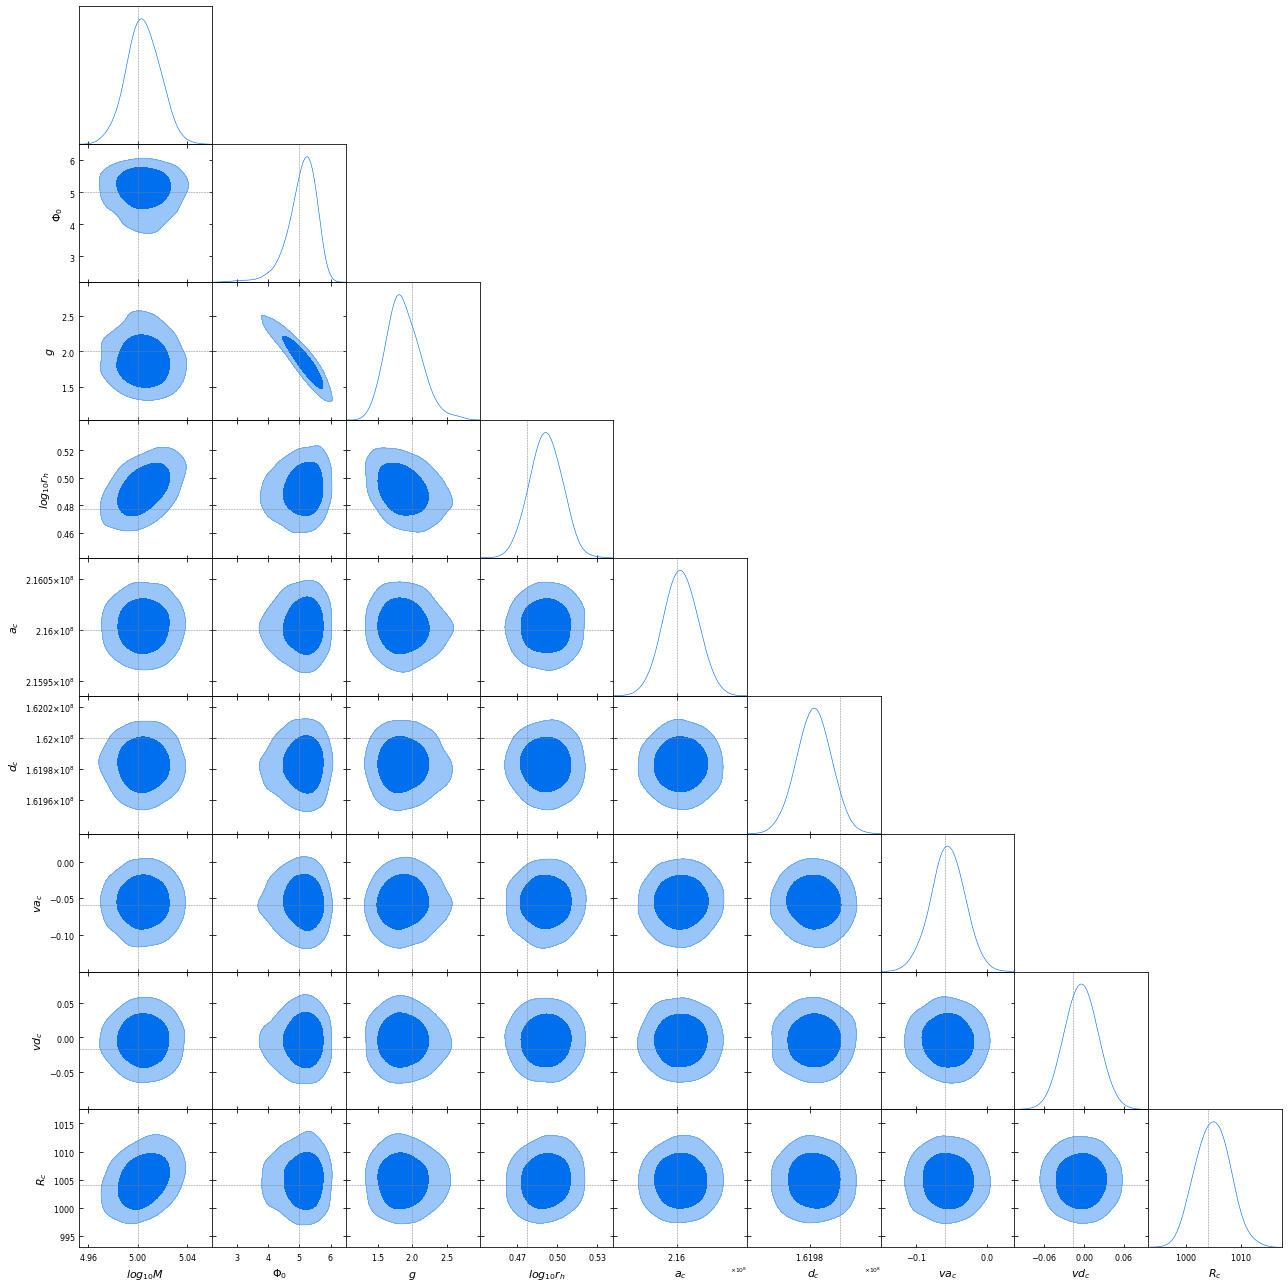

In [5]:
from jax import numpy as jnp
import jax
from coordinate_transform_jax import StC, CtS
def sky_center(ip,ic):
    rad_to_mas = 180/pi*60*60*10**3
    center_param = ic
    ac = center_param[0]*rad_to_mas
    dc = center_param[1]*rad_to_mas
    pc = 1000/center_param[2]
    po_c = StC(jnp.array([ac,dc,pc,1,1,1]))
    phase_car_c = np.array([po_c[0],po_c[1],po_c[2],center_param[3],center_param[4],center_param[5]])
    sky_c = np.array(CtS(jnp.array(phase_car_c)))
    return sky_c

from getdist import plots, MCSamples

sky_c = sky_center(ip,ic)
#data_t =np.loadtxt('./data_fit/s%d%d%d%d/s%d%d%d%d-%d.txt' %(ip[0],ip[1],ip[3],ip[2],ip[0],ip[1],ip[3],ip[2],index))

names = ["log10M","Phi0","g","log10rh","ac","dc","vac","vdc","Rc"]
labels =  ["log_{10}M","\Phi_0","g","log_{10}r_h","a_c","d_c","va_c","vd_c","R_c"]
samples = MCSamples(samples=np.transpose(data_t),names = names, labels = labels)

g = plots.get_subplot_plotter()
g.triangle_plot([samples],filled=True,markers={"g": ip[1], "Phi0": ip[0], "log10M": ip[2], "log10rh": np.log10(ip[3]),\
                                                "ac":sky_c[0],"dc":sky_c[1],\
                                               "vac":sky_c[3], "vdc":sky_c[4],"Rc":1000/sky_c[2]})